In [1]:
# Library imports
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import math
import random
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
#import matplotlib.gridspec as gridspec
import pennylane as qml

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
class IrisDataset(Dataset):
    """Pytorch dataloader for the Optical Recognition of Iris Data Set"""

    def __init__(self, csv_file, label='Iris-setosa', transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_file = csv_file
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        # Use pandas to return a dataframe of only zeros
        df = pd.read_csv(self.csv_file)
        df = df.loc[df.iloc[:, -1] == label]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.df.iloc[idx, :-1] #/ np.linalg.norm(self.df.iloc[idx, :-1].to_numpy())
        image = np.array(image)
        image = image.astype(np.float32).reshape(2, 2)

        if self.transform:
            distr = self.transform(image)

        # Return image and label
        return image, 0

In [3]:
image_size = 2
batch_size = 1

transform = transforms.Compose([transforms.ToTensor()])
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'data'))
filename = "norm_setosa.data"
dataset = IrisDataset(csv_file=os.path.join(path,filename), transform=transform)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

In [4]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(image_size * image_size, 8),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 2),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(2, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

In [5]:
# Quantum variables
n_qubits = 3  # Total number of qubits / N
n_a_qubits = 1  # Number of ancillary qubits / N_A
q_depth = 4  # Depth of the parameterised quantum circuit / D
n_generators = 1  # Number of subgenerators for the patch method / N_G

In [6]:
# Quantum simulator
dev = qml.device("lightning.qubit", wires=n_qubits)
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_circuit(noise, weights):

    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(n_qubits)))


# For further info on how the non-linear transform is implemented in Pennylane
# https://discuss.pennylane.ai/t/ancillary-subsystem-measurement-then-trace-out/1532
def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    probsgiven0 /= torch.sum(probs)

    # Post-Processing
    probsgiven = probsgiven0 / torch.norm(probsgiven0) # torch.max(probsgiven0)
    return probsgiven

In [8]:
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""
    
    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)

        # Iterate over all sub-generators

        for params in self.q_params:

            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:
                q_out = partial_measure(elem, params).float().unsqueeze(0)
                patches = torch.cat((patches, q_out))

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)

        return images

In [9]:
real_samples = pd.read_csv(dataset.csv_file)
real_samples = list(real_samples.iloc[:, :-1].to_numpy())

def kl_divergence(new_results):

    """ Kullback–Leibler divergence """
    
    samples = []
    for sample in range(8):
        new_sample = list(new_results[-1].numpy()[sample][0][0]) + list(new_results[-1].numpy()[sample][0][1])
        samples.append(new_sample)

    entropy = 0
    for fake_data_sample in samples:
        for real_data_sample in real_samples:
            #entropy += sum([fake_data_sample[i]*np.log( 1e-3 + (fake_data_sample[i]/real_data_sample[i])) 
            #                    for i in range(len(fake_data_sample))])
            entropy += sum([(fake_data_sample[i] - real_data_sample[i])**2 
                                for i in range(len(fake_data_sample))])


    return entropy

In [10]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 6000 # Number of training iterations
disc_iter = 5  # Number of training iterations of discriminator

In [11]:
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)

# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(8, n_qubits, device=device) * math.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
results = []; loss_gen = []; loss_disc = []; relative_entropy = []

while True:
    for i, (data, _) in enumerate(dataloader):

        # Data for training the discriminator
        data = data.reshape(-1, image_size * image_size)
        real_data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise)

        for _ in range(disc_iter):
        # Training the discriminator
            discriminator.zero_grad()
            outD_real = discriminator(real_data).view(-1)
            outD_fake = discriminator(fake_data.detach()).view(-1)

            errD_real = criterion(outD_real, real_labels)
            errD_fake = criterion(outD_fake, fake_labels)
            # Propagate gradients
            errD_real.backward()
            errD_fake.backward()

            errD = errD_real + errD_fake
            optD.step()

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()

        counter += 1

        loss_gen.append(float(errG))
        loss_disc.append(float(errD))

        # Show loss values
        if counter % 10 == 0:
            test_images = generator(fixed_noise).view(8,1,image_size,image_size).cpu().detach()
            print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')

            # Save images every 50 iterations
            if counter % 50 == 0:
                results.append(test_images)
                rel_entropy = kl_divergence(new_results = results)
                relative_entropy.append(rel_entropy)
                print(f" ----------   Relative entropy : {rel_entropy} ----------")

        if counter == num_iter:
            break
    if counter == num_iter:
        break

Iteration: 10, Discriminator Loss: 1.398, Generator Loss: 0.817
Iteration: 20, Discriminator Loss: 1.390, Generator Loss: 0.783
Iteration: 30, Discriminator Loss: 1.397, Generator Loss: 0.750
Iteration: 40, Discriminator Loss: 1.389, Generator Loss: 0.735
Iteration: 50, Discriminator Loss: 1.393, Generator Loss: 0.720
 ----------   Relative entropy : 305.18276861605693 ----------
Iteration: 60, Discriminator Loss: 1.381, Generator Loss: 0.720
Iteration: 70, Discriminator Loss: 1.387, Generator Loss: 0.707
Iteration: 80, Discriminator Loss: 1.384, Generator Loss: 0.706
Iteration: 90, Discriminator Loss: 1.392, Generator Loss: 0.695
Iteration: 100, Discriminator Loss: 1.387, Generator Loss: 0.696
 ----------   Relative entropy : 304.8932826723146 ----------
Iteration: 110, Discriminator Loss: 1.386, Generator Loss: 0.697
Iteration: 120, Discriminator Loss: 1.390, Generator Loss: 0.690
Iteration: 130, Discriminator Loss: 1.392, Generator Loss: 0.689
Iteration: 140, Discriminator Loss: 1.3

In [114]:
samples = []
for sample in range(len(results[-1])):
    new_sample = list(results[-1].numpy()[sample][0][0]) + list(results[-1].numpy()[sample][0][1])
    samples.append(new_sample)
    print(new_sample)

[0.5590096, 0.6586609, 0.5035236, 0.011752544]
[0.56474936, 0.65861166, 0.4972728, 0.0029286947]
[0.53379357, 0.5268603, 0.661127, 0.01984541]
[0.4907853, 0.47825342, 0.5919312, 0.42428866]
[0.5171734, 0.44568425, 0.7263695, 0.079275094]
[0.5516592, 0.6652863, 0.49789655, 0.07186947]
[0.54798174, 0.59184796, 0.585487, 0.08146782]
[0.5586117, 0.63504046, 0.5332707, 0.017289322]


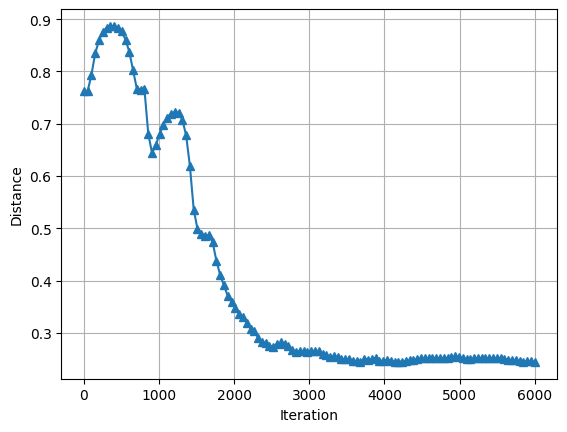

In [17]:
import matplotlib.pyplot as plt
plt.plot(np.linspace(0,6000,120), np.array(relative_entropy)/(len(samples)*50), "-^")
plt.xlabel("Iteration")
plt.ylabel("Distance")
plt.grid()
plt.savefig(r"C:\Users\anton.albino\OneDrive - Sistema FIEB\Documentos\GitHub\quantum-generative-ai\images\distance.png")


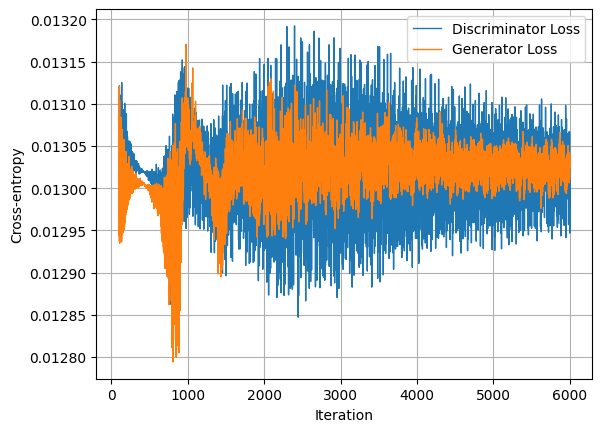

In [126]:
start = 100; end = 6000
plt.plot(np.linspace(start, end, end-start), loss_disc[start:end]/np.linalg.norm(loss_disc[start:end]), linewidth = 1)
plt.plot(np.linspace(start, end, end-start), loss_gen[start:end]/np.linalg.norm(loss_gen[start:end]), linewidth = 1)
plt.grid()
plt.ylabel("Cross-entropy")
plt.xlabel("Iteration")
plt.legend(["Discriminator Loss", "Generator Loss"])
plt.savefig(r"C:\Users\anton.albino\OneDrive - Sistema FIEB\Documentos\GitHub\quantum-generative-ai\images\crossentropy.png")